<a href="https://colab.research.google.com/github/koldo2003/Capstone-Project/blob/main/Dots_Environment_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

This is a turtorial from Open AI, that we modified to fit the needs of the Dots and Boxes environment and research

If you haven't installed the following dependencies, run:

In [ ]:
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
# !pip install 'imageio==2.4.0'
# !pip install pyvirtualdisplay
!pip install tf-agents[reverb]
# !pip install pyglet

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:4 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 

In [ ]:
from __future__ import absolute_import, division, print_function

import base64
# import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
# import PIL.Image
# import pyvirtualdisplay
import reverb

import tensorflow as tf
import Dots
import random
import os
import tempfile
import shutil 

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
# from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

# must import these:
from tf_agents.environments import py_environment
from tf_agents.specs import array_spec
from tf_agents.trajectories import time_step as ts

tempdir = os.getenv("TEST_TMPDIR", tempfile.gettempdir())

RuntimeError: ignored

In [ ]:
tf.version.VERSION

'2.7.0'

## Hyperparameters

In [ ]:
num_iterations = 10000 # @param {type:"integer"}

initial_collect_steps =   1000# @param {type:"integer"}
collect_steps_per_iteration =   1# @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size =   500# @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval =   250# @param {type:"integer"}

num_eval_episodes = 100  # @param {type:"integer"}
eval_interval =   500# @param {type:"integer"}

n, m = 1, 2

## Environment

In Reinforcement Learning (RL), an environment represents the task or problem to be solved. Standard environments can be created in TF-Agents using `tf_agents.environments` suites. TF-Agents has suites for loading environments from sources such as the OpenAI Gym, Atari, and DM Control.

We define a custom environment here.

In [ ]:
def wi(board): # wrap integer
  return np.array([int(x) for x in board],dtype=np.int32)

class Dots_Env(py_environment.PyEnvironment):

  def __init__(self):
    self._action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int32, minimum=0, maximum= m + ((2*m)+1)*n - 1, name='action')
    self._observation_spec = array_spec.BoundedArraySpec(
        shape=(m + ((2*m)+1)*n,), dtype=np.int32, minimum=0, maximum=1, name='observation')
    self._discount_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.float32, minimum=-1.0, maximum=1.0, name='discount')
    self.reset()

  def action_spec(self):
    return self._action_spec

  def observation_spec(self):
    return self._observation_spec

  def discount_spec(self):
    return self._discount_spec

  def _reset(self):
    self._state = Dots.Dots(n,m)
    self.last_reward = 0
    self._episode_ended = False
    return ts.restart(wi(self._state.board))

  def _step(self, action):
    # If last action ended the game, restart
    if self._episode_ended:
    #   print('episode ended, resetting')
      return self.reset()
    
    new_move = action % len(self._state.legal_moves())
    action = self._state.legal_moves()[new_move]


    # If action illegal, just issue a big penalty and stop game
    if action not in self._state.legal_moves():
    #   print(self._num_moves_done,':',self._state,action,'illegal')
      self._episode_ended = True
      return ts.termination(wi(self._state.board),-(n*m+1))
    # Otherwise make their move and give them the appropriate reward
    else:
      score = self._state.score()
      self._state.play(action)
      new_score = self._state.score()
      reward = new_score-score
      # The move may or may not end the game...
      if len(self._state.legal_moves()) > 0:
        # print(self._num_moves_done,':',self._state,action,reward)
        turn = 1 - reward

        while turn!=0:
          if len(self._state.legal_moves())==0:
            self._episode_ended = True
            return ts.termination(wi(self._state.board),reward)
          
          self._state.play(random.choice(self._state.legal_moves()))
          turn = self._state.score() - new_score
          new_score = self._state.score()

        return ts.transition(wi(self._state.board),reward,discount = 1.0)
      else:
        # print(self._num_moves_done,':',self._state,action,reward,'done')
        self._episode_ended = True
        return ts.termination(wi(self._state.board),reward)

env = Dots_Env()
env.time_step_spec()

TimeStep(
{'discount': BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0),
 'observation': BoundedArraySpec(shape=(7,), dtype=dtype('int32'), name='observation', minimum=0, maximum=1),
 'reward': ArraySpec(shape=(), dtype=dtype('float32'), name='reward'),
 'step_type': ArraySpec(shape=(), dtype=dtype('int32'), name='step_type')})

The `environment.step` method takes an `action` in the environment and returns a `TimeStep` tuple containing the next observation of the environment and the reward for the action.

The `time_step_spec()` method returns the specification for the `TimeStep` tuple. Its `observation` attribute shows the shape of observations, the data types, and the ranges of allowed values. The `reward` attribute shows the same details for the reward.


In [ ]:
print('Observation Spec:')
print(env.time_step_spec().observation)

Observation Spec:
BoundedArraySpec(shape=(7,), dtype=dtype('int32'), name='observation', minimum=0, maximum=1)


In [ ]:
print('Reward Spec:')
print(env.time_step_spec().reward)

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


The `action_spec()` method returns the shape, data types, and allowed values of valid actions.

In [ ]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int32'), name='action', minimum=0, maximum=6)


Usually two environments are instantiated: one for training and one for evaluation. 

In [ ]:
train_py_env = Dots_Env()
eval_py_env = Dots_Env()

Our environment, like most environments, is written in pure Python. This is converted to TensorFlow using the `TFPyEnvironment` wrapper.

The original environment's API uses Numpy arrays. The `TFPyEnvironment` converts these to `Tensors` to make it compatible with Tensorflow agents and policies.


In [ ]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

## Agent

The algorithm used to solve an RL problem is represented by an `Agent`. TF-Agents provides standard implementations of a variety of `Agents`, including:

-   [DQN](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf) (used in this tutorial)
-   [REINFORCE](https://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf)
-   [DDPG](https://arxiv.org/pdf/1509.02971.pdf)
-   [TD3](https://arxiv.org/pdf/1802.09477.pdf)
-   [PPO](https://arxiv.org/abs/1707.06347)
-   [SAC](https://arxiv.org/abs/1801.01290)

The DQN agent can be used in any environment which has a discrete action space.

At the heart of a DQN Agent is a `QNetwork`, a neural network model that can learn to predict `QValues` (expected returns) for all actions, given an observation from the environment.

We will use `tf_agents.networks.` to create a `QNetwork`. The network will consist of a sequence of `tf.keras.layers.Dense` layers, where the final layer will have 1 output for each possible action.

In [ ]:
fc_layer_params = (20,20) # (100, 50)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

Now use `tf_agents.agents.dqn.dqn_agent` to instantiate a `DqnAgent`. In addition to the `time_step_spec`, `action_spec` and the QNetwork, the agent constructor also requires an optimizer (in this case, `AdamOptimizer`), a loss function, and an integer step counter.

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

## Policies

A policy defines the way an agent acts in an environment. Typically, the goal of reinforcement learning is to train the underlying model until the policy produces the desired outcome.

Agents contain two policies: 

-   `agent.policy` — The main policy that is used for evaluation and deployment.
-   `agent.collect_policy` — A second policy that is used for data collection.


In [ ]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

Policies can be created independently of agents. For example, use `tf_agents.policies.random_tf_policy` to create a policy which will randomly select an action for each `time_step`.

In [ ]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

To get an action from a policy, call the `policy.action(time_step)` method. The `time_step` contains the observation from the environment. This method returns a `PolicyStep`, which is a named tuple with three components:

-   `action` — the action to be taken (in this case, `0` or `1`)
-   `state` — used for stateful (that is, RNN-based) policies
-   `info` — auxiliary data, such as log probabilities of actions

In [ ]:
example_environment = tf_py_environment.TFPyEnvironment(Dots_Env())

In [ ]:
time_step = example_environment.reset()
time_step

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[0, 0, 0, 0, 0, 0, 0]], dtype=int32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})

In [ ]:
random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([3], dtype=int32)>, state=(), info=())

## Metrics and Evaluation

The most common metric used to evaluate a policy is the average return. The return is the sum of rewards obtained while running a policy in an environment for an episode. Several episodes are run, creating an average return.

The following function computes the average return of a policy, given the policy, environment, and a number of episodes.


In [ ]:
def compute_avg_return(environment, policy, num_episodes=10,printout=False):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    if printout:
      print("NEW EPISODE:\n------------")
      print(time_step)
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      if printout:
        print("This is the move I played:",action_step.action.numpy()[0])
        print(''.join([str(x) for x in time_step.observation.numpy()]))
      episode_return += time_step.reward
    if printout:
      print("REWARD FOR THAT EPISODE:",episode_return.numpy()[0])
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

Running this computation on the `random_policy` shows a baseline performance in the environment.

In [ ]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

0.51

## Replay Buffer

In order to keep track of the data collected from the environment, we will use [Reverb](https://deepmind.com/research/open-source/Reverb), an efficient, extensible, and easy-to-use replay system by Deepmind. It stores experience data when we collect trajectories and is consumed during training.

This replay buffer is constructed using specs describing the tensors that are to be stored, which can be obtained from the agent using agent.collect_data_spec.


In [ ]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)

For most agents, `collect_data_spec` is a named tuple called `Trajectory`, containing the specs for observations, actions, rewards, and other items.

In [ ]:
agent.collect_data_spec

Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(6, dtype=int32)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(7,), dtype=tf.int32, name='observation', minimum=array(0, dtype=int32), maximum=array(1, dtype=int32)),
 'policy_info': (),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

In [ ]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

## Data Collection

Now execute the random policy in the environment for a few steps, recording the data in the replay buffer.

Here we are using 'PyDriver' to run the experience collecting loop. You can learn more about TF Agents driver in our [drivers tutorial](https://www.tensorflow.org/agents/tutorials/4_drivers_tutorial).

In [ ]:
py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

(TimeStep(
{'discount': array(0., dtype=float32),
 'observation': array([1, 1, 1, 1, 1, 1, 1], dtype=int32),
 'reward': array(2., dtype=float32),
 'step_type': array(2, dtype=int32)}),
 ())

The replay buffer is now a collection of Trajectories.

In [ ]:
# For the curious:
# Uncomment to peel one of these off and inspect it.
# iter(replay_buffer.as_dataset()).next()

The agent needs access to the replay buffer. This is provided by creating an iterable `tf.data.Dataset` pipeline which will feed data to the agent.

Each row of the replay buffer only stores a single observation step. But since the DQN Agent needs both the current and next observation to compute the loss, the dataset pipeline will sample two adjacent rows for each item in the batch (`num_steps=2`).

This dataset is also optimized by running parallel calls and prefetching data.

In [ ]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

dataset

<PrefetchDataset shapes: (Trajectory(
{action: (500, 2),
 discount: (500, 2),
 next_step_type: (500, 2),
 observation: (500, 2, 7),
 policy_info: (),
 reward: (500, 2),
 step_type: (500, 2)}), SampleInfo(key=(500, 2), probability=(500, 2), table_size=(500, 2), priority=(500, 2))), types: (Trajectory(
{action: tf.int32,
 discount: tf.float32,
 next_step_type: tf.int32,
 observation: tf.int32,
 policy_info: (),
 reward: tf.float32,
 step_type: tf.int32}), SampleInfo(key=tf.uint64, probability=tf.float64, table_size=tf.int64, priority=tf.float64))>

In [ ]:
iterator = iter(dataset)
print(iterator)

In [ ]:
# For the curious:
# Uncomment to see what the dataset iterator is feeding to the agent.
# Compare this representation of replay data 
# to the collection of individual trajectories shown earlier.

# iterator.next()

## Training the agent

Two things must happen during the training loop:

-   collect data from the environment
-   use that data to train the agent's neural network(s)

This example also periodicially evaluates the policy and prints the current score.

The following will take ~5 minutes to run.

In [ ]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

0.42

In [ ]:
# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

In [ ]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]
returns

[0.4]

In [ ]:
try:
  %%time
except:
  pass

# Reset the environment.
time_step = train_py_env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

#sets up checkpointer
shutil.rmtree(tempdir)
checkpoint_dir = os.path.join(tempdir, 'checkpoint')
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
    replay_buffer=replay_buffer
)


last_avg_return = None # haven't trained yet
for _ in range(num_iterations):

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss
  
  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))

    if last_avg_return is None or avg_return >= last_avg_return:
      last_avg_return = avg_return
      train_checkpointer.save(tf.compat.v1.train.get_global_step()) #save agent
      print(f'This is a new best: {avg_return}')
    else:
      print('Returning to previous policy...')
    
    train_checkpointer.initialize_or_restore() #restore agent
    
    returns.append(last_avg_return)
  

CPU times: user 0 ns, sys: 4 µs, total: 4 µs
Wall time: 7.39 µs
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


step = 250: loss = 0.21376970410346985
step = 500: loss = 0.22822412848472595
step = 500: Average Return = 0.699999988079071
This is a new best: 0.699999988079071
step = 750: loss = 0.17425794899463654
step = 1000: loss = 0.18558482825756073
step = 1000: Average Return = 0.9700000286102295
This is a new best: 0.9700000286102295
step = 1250: loss = 0.1609320044517517
step = 1500: loss = 0.23618772625923157
step = 1500: Average Return = 1.0099999904632568
This is a new best: 1.0099999904632568
step = 1750: loss = 0.13918426632881165
step = 2000: loss = 0.13328835368156433
step = 2000: Average Return = 0.7699999809265137
Returning to previous policy...
step = 2250: loss = 0.18023033440113068
step = 2500: loss = 0.15701410174369812
step = 2500: Average Return = 0.8999999761581421
Returning to previous policy...
step = 2750: loss = 0.2123592644929886
step = 3000: loss = 0.13178138434886932
step = 3000: Average Return = 1.0099999904632568
This is a new best: 1.0099999904632568
step = 3250: l

In [ ]:
compute_avg_return(eval_env, agent.policy, 2,True)

NEW EPISODE:
------------
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[0, 0, 0, 0, 0, 0, 0]], dtype=int32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
This is the move I played: 6
[0 0 1 0 0 0 1]
This is the move I played: 3
[0 1 1 0 1 0 1]
This is the move I played: 3
[1 1 1 1 1 1 1]
REWARD FOR THAT EPISODE: 0.0
NEW EPISODE:
------------
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[0, 0, 0, 0, 0, 0, 0]], dtype=int32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
This is the move I played: 6
[0 0 1 0 

0.5

In [ ]:
compute_avg_return(eval_env, agent.policy, 1000)

1.003

## Visualization


### Plots

Use `matplotlib.pyplot` to chart how the policy improved during training.

One iteration of `Cartpole-v0` consists of 200 time steps. The environment gives a reward of `+1` for each step the pole stays up, so the maximum return for one episode is 200. The charts shows the return increasing towards that maximum each time it is evaluated during training. (It may be a little unstable and not increase monotonically each time.)

(0.36100000888109207, 15.0)

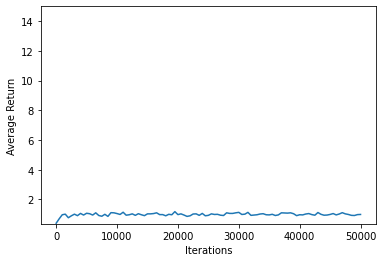

In [ ]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=15)